In [22]:
import pandas as pd
import numpy as np
import missingno as msno
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")
from nltk.corpus import stopwords
from nltk.tokenize import RegexpTokenizer
from nltk.corpus import wordnet as wn
from nltk.stem.wordnet import WordNetLemmatizer
from nltk import word_tokenize, pos_tag
from collections import defaultdict
tokenizer = RegexpTokenizer(r'\w+')
stop_words = stopwords.words('english')
from fuzzywuzzy import fuzz
import gensim
from tqdm import tqdm
from scipy.stats import skew, kurtosis
from scipy.spatial.distance import cosine,euclidean, cityblock

# Data Description <br>

The dataset is of quora consisting of 400000+ labeled(duplicate or non duplicate) question pairs <br><br>
**Objective** : To classify whether question pairs are duplicate or not. <br><br>
We have following fields 
- **id** : the id of a training set question pair
- **qid1, qid2** : Unique ids of each question (only available in train.csv)
- **question1, question2** -: the full text of each question
- **is_duplicate** - The target variable, set to 1 if question1 and question2 have essentially the same meaning, and 0 otherwise.

In [2]:
data = pd.read_csv("./train.csv")
print(data.shape)
data.head(10)

(404290, 6)


,id,qid1,qid2,question1,question2,is_duplicate
0,0,1,2,What is the step by step guide to invest in sh...,What is the step by step guide to invest in sh...,0
1,1,3,4,What is the story of Kohinoor (Koh-i-Noor) Dia...,What would happen if the Indian government sto...,0
2,2,5,6,How can I increase the speed of my internet co...,How can Internet speed be increased by hacking...,0
3,3,7,8,Why am I mentally very lonely? How can I solve...,Find the remainder when [math]23^{24}[/math] i...,0
4,4,9,10,"Which one dissolve in water quikly sugar, salt...",Which fish would survive in salt water?,0
5,5,11,12,Astrology: I am a Capricorn Sun Cap moon and c...,"I'm a triple Capricorn (Sun, Moon and ascendan...",1
6,6,13,14,Should I buy tiago?,What keeps childern active and far from phone ...,0
7,7,15,16,How can I be a good geologist?,What should I do to be a great geologist?,1
8,8,17,18,When do you use シ instead of し?,"When do you use ""&"" instead of ""and""?",0
9,9,19,20,Motorola (company): Can I hack my Charter Moto...,How do I hack Motorola DCX3400 for free internet?,0


### Do we have missing values in data ?

<AxesSubplot:>

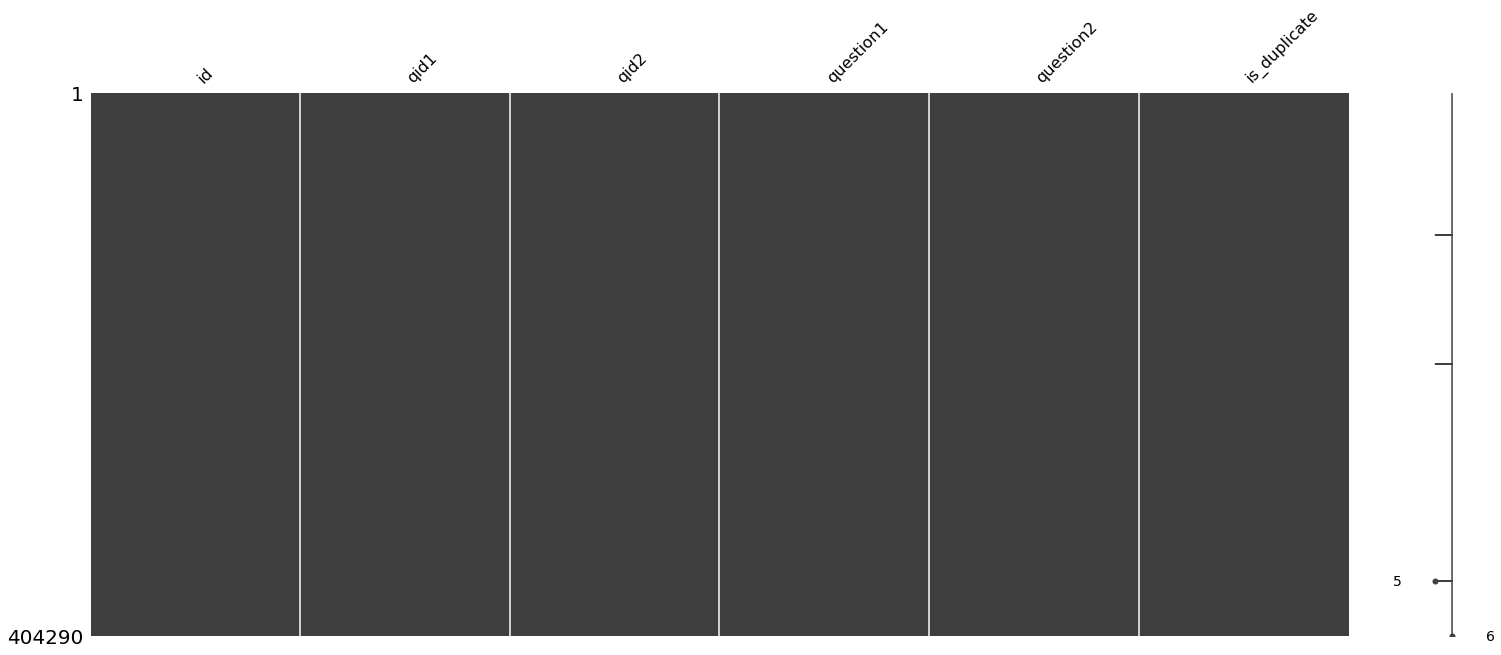

In [3]:
msno.matrix(data)

> It's clearly visible that our data does not have any missing values.

### Class Distribution

<AxesSubplot:xlabel='is_duplicate', ylabel='count'>

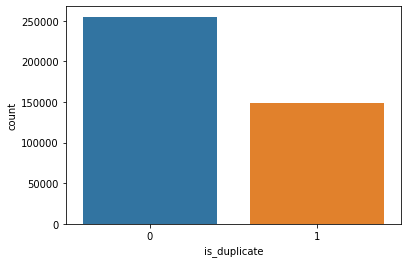

In [4]:
sns.countplot(data['is_duplicate'])

In [5]:
print('-> Total number of question pairs for training:   {}'.format(len(data)))
print('-> Question pairs are not Similar (is_duplicate = 0):   {}%'.format(100 - round(data['is_duplicate'].mean()*100, 2)))
print('-> Question pairs are Similar (is_duplicate = 1):   {}%'.format(round(data['is_duplicate'].mean()*100, 2)))

-> Total number of question pairs for training:   404290
-> Question pairs are not Similar (is_duplicate = 0):   63.08%
-> Question pairs are Similar (is_duplicate = 1):   36.92%


>  Total number of question pairs for training:   **404290** <br>
>  Question pairs are not Similar (is_duplicate = 0):   **63.08%** <br>
>Question pairs are Similar (is_duplicate = 1):   **36.92%**

# Text Cleaning<br>

1. **Tokenize** : It consists of splitting an entire text into small units, also known as tokens.
2. **Remove Stop Words** : Stop words is a commonly used word (such as “the”, “a”, “an”, “in”) that does not add any relevant information to context.
3. **Lemmatization** : Lemmatization is the grouping together of different forms of the same word.

In [6]:
data_short = pd.read_csv("./train.csv", nrows = 50)
data_short.drop(["qid1", "qid2", 'id'], axis = 1, inplace = True)
pd.options.display.max_colwidth = 100
data_short.head(5)

,id,question1,question2,is_duplicate
0,0,What is the step by step guide to invest in share market in india?,What is the step by step guide to invest in share market?,0
1,1,What is the story of Kohinoor (Koh-i-Noor) Diamond?,What would happen if the Indian government stole the Kohinoor (Koh-i-Noor) diamond back?,0
2,2,How can I increase the speed of my internet connection while using a VPN?,How can Internet speed be increased by hacking through DNS?,0
3,3,Why am I mentally very lonely? How can I solve it?,"Find the remainder when [math]23^{24}[/math] is divided by 24,23?",0
4,4,"Which one dissolve in water quikly sugar, salt, methane and carbon di oxide?",Which fish would survive in salt water?,0


In [7]:
class text_processing:
    
    def __init__(self, my_dataframe):
        '''
         my_dataframe : pandas dataframe, all changes made in this dataframe will 
                        reflect back in original one (changes are in_place). 
        '''

        self.my_dataframe = my_dataframe
        
    # Removes puncutations and tokenize the sentence.
    def tokenize_helper(self, words):
        words = str(words).lower()
        words = tokenizer.tokenize(words)
        return words
    
    def tokenize(self):
        self.my_dataframe['question1'] = self.my_dataframe['question1'].apply(self.tokenize_helper)
        self.my_dataframe['question2'] = self.my_dataframe['question2'].apply(self.tokenize_helper)
            
            
    # Remove Stopwords 
    def stopword_helper(self, words):
        words = [w for w in words if w not in stop_words]
        return words
            
    def remove_stop_words(self):
        self.my_dataframe['question1'] = self.my_dataframe['question1'].apply(self.stopword_helper)
        self.my_dataframe['question2'] = self.my_dataframe['question2'].apply(self.stopword_helper)
        
        
    # Lemmitiazation with POS tagging
    def lemmi_helper(self, tokens):
        
        tag_map = defaultdict(lambda : wn.NOUN)
        tag_map['J'] = wn.ADJ
        tag_map['V'] = wn.VERB
        tag_map['R'] = wn.ADV

        lmtzr = WordNetLemmatizer()
        s = []
        for token, tag in pos_tag(tokens):
            lemma = lmtzr.lemmatize(token, tag_map[tag[0]])
            s.append(lemma)
            
        return ' '.join(s)
    
    
    def do_lemmatization(self):
        self.my_dataframe['question1'] = self.my_dataframe['question1'].apply(self.lemmi_helper)
        self.my_dataframe['question2'] = self.my_dataframe['question2'].apply(self.lemmi_helper)


In [8]:
data_short_cleaned = data_short.copy()
obj = text_processing(data_short_cleaned)
obj.tokenize()
obj.remove_stop_words()
obj.do_lemmatization()

##  Original vs Cleaned Text

In [9]:
data_short.head()

,id,question1,question2,is_duplicate
0,0,What is the step by step guide to invest in share market in india?,What is the step by step guide to invest in share market?,0
1,1,What is the story of Kohinoor (Koh-i-Noor) Diamond?,What would happen if the Indian government stole the Kohinoor (Koh-i-Noor) diamond back?,0
2,2,How can I increase the speed of my internet connection while using a VPN?,How can Internet speed be increased by hacking through DNS?,0
3,3,Why am I mentally very lonely? How can I solve it?,"Find the remainder when [math]23^{24}[/math] is divided by 24,23?",0
4,4,"Which one dissolve in water quikly sugar, salt, methane and carbon di oxide?",Which fish would survive in salt water?,0


In [10]:
data_short_cleaned.head()

,id,question1,question2,is_duplicate
0,0,step step guide invest share market india,step step guide invest share market,0
1,1,story kohinoor koh noor diamond,would happen indian government steal kohinoor koh noor diamond back,0
2,2,increase speed internet connection use vpn,internet speed increase hack dns,0
3,3,mentally lonely solve,find remainder math 23 24 math divide 24 23,0
4,4,one dissolve water quikly sugar salt methane carbon di oxide,fish would survive salt water,0


<br><br><br>
# Basic Features <br>
- **Length of questions** : Total number of characters in questions <br>
- **Difference in length of questions** : Difference between length of two questions. <br>
- **Number of words in questions** : Number of words in a question. <br>
- **Number of Common words in both questions** : Common words between 2 questions <br>
- **Number of distinct characters in questions** : Distinct characters used in a question. 

In [11]:
class basic_features:
    
    def __init__(self, my_dataframe):
        self.my_dataframe = my_dataframe
        
    def create_basic_features(self):
        self.my_dataframe['len_q1'] = self.my_dataframe.question1.apply(lambda x: len(str(x)))
        self.my_dataframe['len_q2'] = self.my_dataframe.question2.apply(lambda x: len(str(x)))
        self.my_dataframe['diff_len'] = self.my_dataframe.len_q1 - self.my_dataframe.len_q2
        self.my_dataframe['len_word_q1'] = self.my_dataframe.question1.apply(lambda x: len(str(x).split()))
        self.my_dataframe['len_word_q2'] = self.my_dataframe.question2.apply(lambda x: len(str(x).split()))
        self.my_dataframe['common_words'] = self.my_dataframe.apply(lambda x: len(set(str(x['question1']).lower().split()).intersection(set(str(x['question2']).lower().split()))), axis=1)
        self.my_dataframe['len_char_q1'] = self.my_dataframe.question1.apply(lambda x: len(''.join(set(str(x).replace(' ', '')))))
        self.my_dataframe['len_char_q2'] = self.my_dataframe.question2.apply(lambda x: len(''.join(set(str(x).replace(' ', '')))))

In [13]:
basic_feature_obj = basic_features(data_short_cleaned)
basic_feature_obj.create_basic_features()
data_short_cleaned.head()

,id,question1,question2,is_duplicate,len_q1,len_q2,diff_len,len_word_q1,len_word_q2,common_words,len_char_q1,len_char_q2
0,0,step step guide invest share market india,step step guide invest share market,0,41,35,6,7,6,5,15,15
1,1,story kohinoor koh noor diamond,would happen indian government steal kohinoor koh noor diamond back,0,31,67,-36,5,10,4,12,20
2,2,increase speed internet connection use vpn,internet speed increase hack dns,0,42,32,10,6,5,3,13,12
3,3,mentally lonely solve,find remainder math 23 24 math divide 24 23,0,21,43,-22,3,9,0,10,14
4,4,one dissolve water quikly sugar salt methane carbon di oxide,fish would survive salt water,0,60,29,31,10,5,2,22,14


# Fuzzy Features <br>

Fuzzy String Matching, also known as Approximate String Matching, is the process of finding strings that approximately match a pattern. Higher the ratio, more similar are the strings.
- **Fuzzy Ratio** :  Calculates the standard Levenshtein distance similarity ratio between two sequences. (Edit Distance)
- **Partial Ratio** : The partial ratio helps us to perform substring matching. This takes the shortest string and compares it with all the substrings of the same length. Partial_ratio() just checks if either string is a substring of the other.
- **Token Sort Ratio** : The strings are tokenized and pre-processed by converting to lower case,the strings are then sorted alphabetically and then ratio is calculated.
- **Partial Token Sort Ratio** : Same as Token sort ratio but with substring matching.
- **Token Set Ratio** : Token set ratio performs a set operation that takes out the common tokens.Same repeated words do not matter.
- **Partial Token Set Ratio** :Same as token set but with substring matching.

 

In [14]:
class fuzzy_features:
    def __init__(self, my_dataframe):
        self.my_dataframe = my_dataframe
        
    def create_fuzzy_features(self):
        self.my_dataframe['fuzz_ratio'] = self.my_dataframe.apply(lambda x: fuzz.ratio(str(x['question1']), str(x['question2'])), axis=1)
        self.my_dataframe['fuzz_partial_ratio'] = self.my_dataframe.apply(lambda x: fuzz.partial_ratio(str(x['question1']), str(x['question2'])), axis=1)
        self.my_dataframe['fuzz_partial_token_sort_ratio'] = self.my_dataframe.apply(lambda x: fuzz.partial_token_sort_ratio(str(x['question1']), str(x['question2'])), axis=1)
        self.my_dataframe['fuzz_partial_token_set_ratio'] = self.my_dataframe.apply(lambda x: fuzz.partial_token_set_ratio(str(x['question1']), str(x['question2'])), axis=1)
        self.my_dataframe['fuzz_token_set_ratio'] = self.my_dataframe.apply(lambda x: fuzz.token_set_ratio(str(x['question1']), str(x['question2'])), axis=1)
        self.my_dataframe['fuzz_token_sort_ratio'] = self.my_dataframe.apply(lambda x: fuzz.token_sort_ratio(str(x['question1']), str(x['question2'])), axis=1)

In [19]:
fuzzy_features_obj = fuzzy_features(data_short_cleaned)
fuzzy_features_obj.create_fuzzy_features()
data_short_cleaned.head()

,id,question1,question2,is_duplicate,len_q1,len_q2,diff_len,len_word_q1,len_word_q2,common_words,len_char_q1,len_char_q2,fuzz_ratio,fuzz_partial_ratio,fuzz_partial_token_sort_ratio,fuzz_partial_token_set_ratio,fuzz_token_set_ratio,fuzz_token_sort_ratio
0,0,step step guide invest share market india,step step guide invest share market,0,41,35,6,7,6,5,15,15,92,100,91,100,100,92
1,1,story kohinoor koh noor diamond,would happen indian government steal kohinoor koh noor diamond back,0,31,67,-36,5,10,4,12,20,57,90,81,100,89,59
2,2,increase speed internet connection use vpn,internet speed increase hack dns,0,42,32,10,6,5,3,13,12,51,56,81,100,84,70
3,3,mentally lonely solve,find remainder math 23 24 math divide 24 23,0,21,43,-22,3,9,0,10,14,22,24,33,29,23,22
4,4,one dissolve water quikly sugar salt methane carbon di oxide,fish would survive salt water,0,60,29,31,10,5,2,22,14,43,52,55,100,51,40


# Similarity Measure Features <br>
- **Word Mover's Distance** :  The intuition behind the method is that we find the minimum “traveling distance” between documents, in other words the most efficient way to “move” the distribution of document 1 to the distribution of document 2. <br> <br>
- **Jaccard Similarity** : The measurement emphasizes similarity between finite sample sets, and is formally defined as the size of the intersection divided by the size of the union of the sample sets. 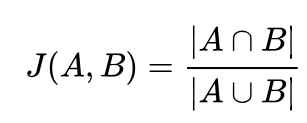

- **Cosine Similarity** : Cosine similarity measures the orientation of two n-dimensional sample vectors irrespective to their magnitude. It is calculated by the dot product of two numeric vectors, and it is normalized by the product of the vector lengths, so that output values close to 1 indicate high similarity.
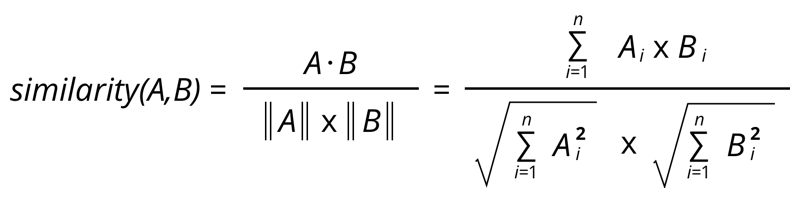

- **Euclidian Diatance** : The Euclidean distance is a distance measure between two points or or vectors in a two- or multidimensional (Euclidean) space based on Pythagoras' theorem. The distance is calculated by taking the square root of the sum of the squared pair-wise distances of every dimension. 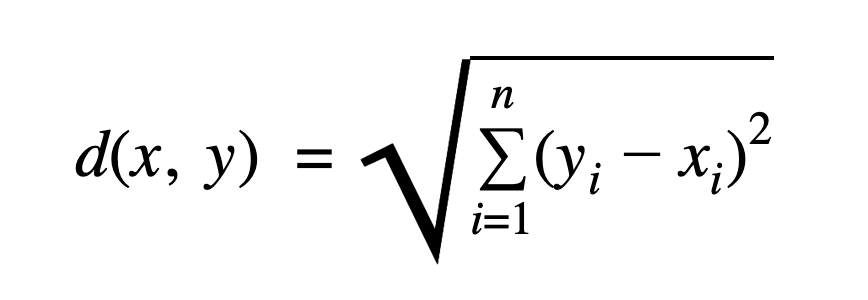

- **Manhattan Diatance** : The Manhattan distance (sometimes also called Taxicab distance) metric is related to the Euclidean distance, but instead of calculating the shortest diagonal path ("beeline") between two points, it calculates the distance based on gridlines. 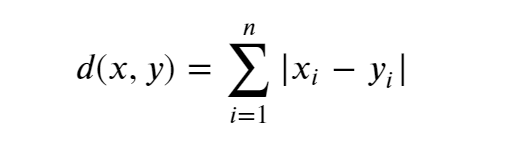

In [26]:
model = gensim.models.KeyedVectors.load_word2vec_format('../input/googles-trained-word2vec-model-in-python/GoogleNews-vectors-negative300.bin', binary=True)
def sent2vec(s):
        M = []
        for w in s.split():
            try:
                M.append(model[w])
            except:
                continue
        M = np.array(M)
        v = M.sum(axis=0)
        return v / np.sqrt((v ** 2).sum())
    

def wmd(s1, s2):
    s1 = str(s1).lower().split()
    s2 = str(s2).lower().split()
    return model.wmdistance(s1, s2)
    
    
def jaccard_similarity(list1, list2):
    list1 = list1.split()
    list2 = list2.split()
    s1 = set(list1)
    s2 = set(list2)
    return float(len(s1.intersection(s2)) / len(s1.union(s2)))
    
        
class similarity_measure_features:
    
    def __init__(self, my_dataframe):
        self.my_dataframe = my_dataframe
        self.question1_vectors = np.zeros((self.my_dataframe.shape[0], 300))
        self.question2_vectors = np.zeros((self.my_dataframe.shape[0], 300))
        
    
    def convert_sentence_to_vector(self):
    
        for i, q in tqdm(enumerate(self.my_dataframe.question1.values)):
            self.question1_vectors[i, :] = sent2vec(str(q))

        for i, q in tqdm(enumerate(self.my_dataframe.question2.values)):
            self.question2_vectors[i, :] = sent2vec(str(q))
    
    
    def create_distance_based_feature(self):

            self.my_dataframe['cosine_similarity'] = [1 - cosine(x, y) for (x, y) in zip(np.nan_to_num(self.question1_vectors), -  -
                                                               np.nan_to_num(self.question2_vectors))]

            self.my_dataframe['jaccard_similarity'] = [jaccard_similarity(str(x), str(y)) for x, y in zip(self.my_dataframe.question1.values,self.my_dataframe.question2.values)]

            self.my_dataframe['euclidean_distance'] = [euclidean(x, y) for (x, y) in zip(np.nan_to_num(self.question1_vectors),
                                                                       np.nan_to_num(self.question2_vectors))]
            
            self.my_dataframe['wmd'] = self.my_dataframe.apply(lambda x: wmd(x['question1'], x['question2']), axis=1)
            
            
            self.my_dataframe['cityblock_distance'] = [cityblock(x, y) for (x, y) in zip(np.nan_to_num(self.question1_vectors),
                                                          np.nan_to_num(self.question2_vectors))]

In [27]:
similarity_measure_features_obj = similarity_measure_features(data_short_cleaned)
similarity_measure_features_obj.convert_sentence_to_vector()
similarity_measure_features_obj.create_distance_based_feature()

50it [00:00, 18542.46it/s]
50it [00:00, 19555.69it/s]


In [29]:
data_short_cleaned.head()

,id,question1,question2,is_duplicate,len_q1,len_q2,diff_len,len_word_q1,len_word_q2,common_words,...,fuzz_partial_ratio,fuzz_partial_token_sort_ratio,fuzz_partial_token_set_ratio,fuzz_token_set_ratio,fuzz_token_sort_ratio,cosine_similarity,jaccard_similarity,euclidean_distance,wmd,cityblock_distance
0,0,step step guide invest share market india,step step guide invest share market,0,41,35,6,7,6,5,...,100,91,100,100,92,0.931028,0.833333,0.371408,0.198042,5.081614
1,1,story kohinoor koh noor diamond,would happen indian government steal kohinoor koh noor diamond back,0,31,67,-36,5,10,4,...,90,81,100,89,59,0.691313,0.363636,0.785732,0.879870,11.028160
2,2,increase speed internet connection use vpn,internet speed increase hack dns,0,42,32,10,6,5,3,...,56,81,100,84,70,0.797906,0.375000,0.635757,0.587479,8.829532
3,3,mentally lonely solve,find remainder math 23 24 math divide 24 23,0,21,43,-22,3,9,0,...,24,33,29,23,22,0.337095,0.000000,1.151438,1.274353,16.075622
4,4,one dissolve water quikly sugar salt methane carbon di oxide,fish would survive salt water,0,60,29,31,10,5,2,...,52,55,100,51,40,0.630007,0.153846,0.860225,0.972994,12.103178
